In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from kernels import Kernels

# Bi-directional reflectance density function (BRDF) modelling for fun and profit

## Introduction
This post introduces simple BRDF modelling (i.e. how can we account for the variation in surface reflectance due to  acquisition geometry?) using some MODIS data. The techniques are fairly general, and can be applied to other sensors, but generally speaking, we are thinking of wide swath coarse resolution sensors such as Sentinel3/OLCI or VIIRS.

BRDF effects are basically effects derived from changes in both illumination and sensor geometry (or in the context of remote sensing in the solar reflective domain, sun and sensor position). The land surface is generally sepaking *anisotropic*, so that its reflectance varies with changes in the aforementioned geometries. This effect, particularly egregious in wide swath sensors results in a typical noise-like "fuzziness" if you look at a time series of data. The effect is physical, and if you don't compensate for it, it looks for noise, and can even cause important biases that may lead you to pretty wrong conclusions [e.g.](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20140017088.pdf)[DOI:10.1038/nature1300](http://doi.org/10.1038/nature1300)

<div>
<img style="float: right;" src="http://www.doc.gold.ac.uk/~mas02fl/MSC101/Graphics/Pics/brdfdemo.gif" width="250"/>
</div>



A particularly simple way of dealing with BRDF effects is by using linear kernel models. These models are reduced physics versions of more complex radiative tranfer models with some empirical considerations to further simplify things. Since we are only interested in the shape of the BRDF, we can lump the parameters into some constants of limited physical explanatory value, and do a few simplifications so that we can write the the observed reflectance at band $\lambda_i$ as:

$$
\rho^{\lambda_i}(\Omega, Omega') = \sum_{i=1}^{N_{kern}}f_{i}(\lambda_i)K_{i}(\Omega, \Omega'),
$$

where we have $N_{kern}$ kernels, typically 3, and the acquisition geometry is given by $(\Omega, Omega')$. The three kernels that are typically used are those that have been popularised by the MODIS albedo product (MCD43):

*  An isotropic kernel, ($K_{iso}=1$), accounting for isotropic  BRDF effects (bet you didn't see that one coming...),
*  A volumetric scattering kernel ($K_{vol}(\Omega, \Omega')$), a simplified version of volume scattering as seen in Ross (1981),
*  A geometric scattering that aims to mimick surface scattering and shadowing, $K_{geo}(\Omega, \Omega')$.

While different families of these kernels are used, we use the Ross-ThickLiSparse-Reciprocal kernels (these have been evaluated and found to be quite general and overall "pretty good"). Note that the kernel functions are independent of wavelength: they just describe a shape in $(\Omega, \Omega')$ space.

The problem stated above cannot be solved on an observation by observation basis: there are 3 parameters per band, and only one observation, so the system is underdetermined. If we assume that the parameters can be related to land surface parameters, and we assume that within a period there is no change (or at least change is slow), a way around this is **temporal compositing**, where all the observations within a given period are inverted together to provide a unique set of kernel weights associated with the entire period.

It is important to take uncertainty in the observations into account, as we don't measure $\rho^{\lambda_i}$ , but rather
$\hat{\rho}^{\lambda_i} = \rho^{\lambda_i} + \epsilon^{\lambda_i}$, where $\epsilon^{\lambda_i}$ is additive noise, typically modelled as zero mean and with a known variance (this is bollocks, by the way, as the uncertainty will vary in function of the atmospheric correction. But since no-one bothers with this, we'll assume that it's constant!).

## Ill-posedness

The problem of inverting RT models (be they linear or not) is typically *ill-posed*. By contrast, a well-posed problem (in the Hadamard sense) is one where:

1. A solution exists
2. The solution is unique
3. The solution's behavior hardly changes when there's a slight change in the initial condition

In this case, due to the uncertainty introduced by the noise (and limited angular sampling), point 2 is not typically met, resulting in many configurations of kernel weights that provide an adequate representation of the observations. Compositing is a good way of increasing the angular sampling and reducing the noise, but it can only be taken that far: too long a compositing window, and the assumption of static land surface properties weakens.

## Reading the data

Let's look at some data. The data is stored in a text file, and belongs to a pixel somewhere in Angola. We only have band 2 data here. The first ten lines of the file show the format. The first line is a header, telling us that there are 92 observations, with 7 bands, as well as their centre wavelengths. After the first line, we have individual records with the following format:

*  day of year (DoY)
*  QA flag (1=use, 2=don't use)
*  `vza`, the view zenith angle (in degrees)
*  `vaa`, the view azimuth angle (in degrees)
*  `sza`, the solar/illumiation zenith angle (in degrees)
*  `saa`, the solar/illumiation azimuth angle (in degrees)
*  the reflectance

Typically, we will use `sza`, `vza` and `raa`. `raa=vaa - saa`.

First, we need to get the data. The data is stored in a file in this repository. Let's have a peek...

    



In [2]:
!head -n 10 data.r2023.c87.dat

BRDF 92 7 648 858 470 555 1240 1640 2130
181 1 65.419998 -84.470001 44.130001 20.090000 0.114600 0.243200 0.052800 0.087100 0.328300 0.302300 0.213400 
182 1 23.410000 98.290001 50.220001 35.310001 0.113900 0.218100 0.051100 0.084500 0.315900 0.339000 0.205500 
184 1 44.049999 100.730003 51.910000 38.360001 0.142900 0.269100 0.063400 0.107500 0.359300 0.375000 0.246500 
185 1 40.400002 -82.199997 46.310001 27.700001 0.107000 0.212100 0.051600 0.079900 0.310400 0.310400 0.214100 
186 1 57.720001 101.300003 53.700001 41.259998 0.152700 0.291400 0.064600 0.114800 0.395000 0.382700 0.258700 
187 1 17.770000 -81.010002 47.630001 31.260000 0.111000 0.217700 0.050500 0.081600 0.307600 0.318500 0.205500 
188 0 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
189 1 10.470000 96.879997 49.090000 34.650002 0.117500 0.225000 0.054200 0.087700 0.334600 0.334300 0.231400 
190 1 60.889999 -83.790001 44.070000 22.910000 0.100200 0.212100 0.045900 0.07

OK, so far, so good. let's plot the data and do some crafty plots

Text(0, 0.5, '$\\hat{\\rho}^{NIR}$')

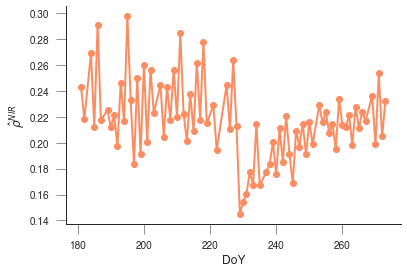

In [3]:
# Read data in, but skip first line
data = np.loadtxt("data.r2023.c87.dat", skiprows=1)
doys = data[:, 0]
qa = data[:, 1]
vza = data[:, 2]
sza = data[:, 4]
raa = data[:, 3] - data[:, 5]
rho = data[:, 7]
plt.plot(doys[qa == 1], rho[qa == 1], 'o-')
plt.xlabel("DoY")
plt.ylabel(r'$\hat{\rho}^{NIR}$')


So we see that there's quite a lot of what appears to be noise over the time series, with a lot of high frequency variation. There's also an obvious drop in reflectance around DoY 228, which in this case was caused by a fire (there's a thermal anomaly on that day there too), and we can see that the reflectance recovers back to normal after that.

I'm telling you that a lot of that random-, noise-like behaviour is mostly changes in view/illumination geometry. 

Let's see if we can use the linear kernel models to... well, model this. First, let's calculate the different $K$ functions as a function of geometry. 

In [4]:
# Generate the kernels,
K_obs = Kernels(vza, sza, raa,
                LiType='Sparse', doIntegrals=False,
                normalise=1, RecipFlag=True, RossHS=False, MODISSPARSE=True,
                RossType='Thick')
n_obs = vza.shape[0]
kern = np.ones((n_obs, 3))  # Store the kernels in an array
kern[:, 1] = K_obs.Ross
kern[:, 2] = K_obs.Li


Let's fit the kernel weights ($f_0, f_1, f_2$) to the observations between DoY 200 and 209.

In [5]:
passer = np.logical_and(qa == 1, np.logical_and(doys > 200, doys <= 209))
obs = rho[passer]
K = kern[passer, :]
(f, rmse, rank, svals) = np.linalg.lstsq(K, obs, rcond=None)
print(f"{'kernel':20s}\t  {'Solved weight':20s}")
for i, k in enumerate(["Isotropic", "Ross", "LiThick"]):
    print(f"{k:20s}\t=>{f[i]:20f}")


kernel              	  Solved weight       
Isotropic           	=>            0.234025
Ross                	=>            0.046412
LiThick             	=>            0.053834


So we have a solution. How good is it? Let's try to forward model the observations:

R2: 0.950517


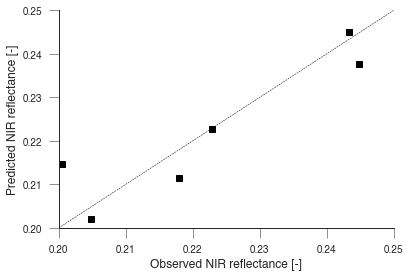

In [6]:
fwd = K.dot(f.T)
print(f"R2: {np.corrcoef (obs, fwd)[1,0]:g}")
plt.plot(obs, fwd, 'sk')
plt.plot([0.2, 0.25], [0.2, 0.25], 'k--', lw=0.5)
plt.ylim(0.2, 0.25)
plt.xlim(0.2, 0.25)
_ = plt.xlabel("Observed NIR reflectance [-]")
_ = plt.ylabel("Predicted NIR reflectance [-]")

That's pretty encouraging: Over around a week, we can predict the observations with our kernels pretty well... We can pack this into a function for convenience:

In [7]:
def invert_composite(qa, doys, rho, kern, doy_min, doy_max):
    """A function to invert reflectance assuming the kernels in `kern`,
    `qa` holds the QA data, `doys` the dates, and `rho` the actual
    observations. Will composite all observations between `doy_min` and
    `doy_max`."""
    passer = np.logical_and(qa == 1, np.logical_and(
        doys > doy_min, doys <= doy_max))
    if np.sum(passer) < 3:
        raise np.linalg.LinAlgError
    obs = rho[passer]
    K = kern[passer, :]
    (f, rmse, rank, svals) = np.linalg.lstsq(K, obs, rcond=None)
    print(f"N. Obs: {np.sum(passer):d}")
    print(f"{'kernel':20s}\t  {'Solved weight':20s}")
    for i, k in enumerate(["Isotropic", "Ross", "LiThick"]):
        print(f"{k:20s}\t=>{f[i]:20f}")
    fwd = K.dot(f.T)
    print(f"R2: {np.corrcoef (obs, fwd)[1,0]:g}")
    _ = plt.plot(obs, fwd, 'sk')
    _ = plt.plot([0.05, 0.3], [0.05, 0.3], 'k--', lw=0.5)
    _ = plt.ylim(0.05, 0.3)
    _ = plt.xlim(0.05, 0.3)
    return obs, fwd, passer, f, rmse


Check we do as we expect...

N. Obs: 9
kernel              	  Solved weight       
Isotropic           	=>            0.234247
Ross                	=>            0.045438
LiThick             	=>            0.054025
R2: 0.951876


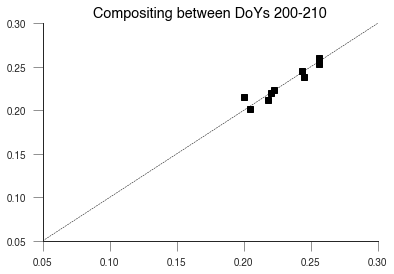

In [8]:
retval = invert_composite ( qa, doys, rho, kern, 200, 210 )
_ = plt.title("Compositing between DoYs 200-210")


Assume the surface parameters are identical over DoY 200-227:

N. Obs: 23
kernel              	  Solved weight       
Isotropic           	=>            0.228393
Ross                	=>            0.081972
LiThick             	=>            0.045487
R2: 0.951493


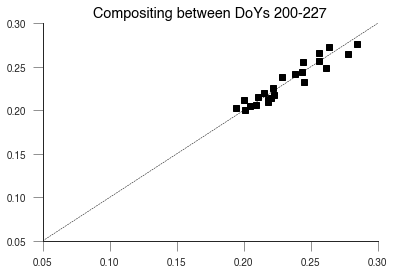

In [9]:
retval = invert_composite ( qa, doys, rho, kern, 200, 227 )
_ = plt.title("Compositing between DoYs 200-227")

Getting carried away: assume the surface parameters are identical over entire period (stupid thing to do, as there's clearly something happening at DoY 228!)

N. Obs: 84
kernel              	  Solved weight       
Isotropic           	=>            0.207380
Ross                	=>            0.110985
LiThick             	=>            0.017489
R2: 0.637027


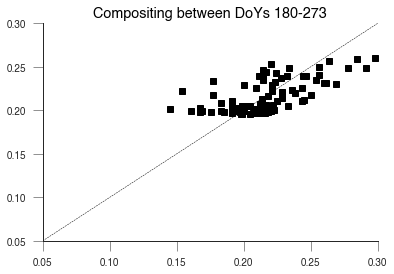

In [10]:
retval = invert_composite ( qa, doys, rho, kern, 180, 273 )
_ = plt.title("Compositing between DoYs 180-273")

So this is a bit rubbish. The asumption of stationary kernel weights is clearly violated here. But maybe we can bunch up observations in say 8 day periods and produce a meaningful tracking of dynamics.

183-191
N. Obs: 7
kernel              	  Solved weight       
Isotropic           	=>            0.222219
Ross                	=>            0.169360
LiThick             	=>            0.037188
R2: 0.925264
191-199
N. Obs: 8
kernel              	  Solved weight       
Isotropic           	=>            0.238978
Ross                	=>            0.057102
LiThick             	=>            0.085679
R2: 0.977485
199-207
N. Obs: 7
kernel              	  Solved weight       
Isotropic           	=>            0.234318
Ross                	=>            0.055160
LiThick             	=>            0.058290
R2: 0.930995
207-215
N. Obs: 8
kernel              	  Solved weight       
Isotropic           	=>            0.228597
Ross                	=>            0.093693
LiThick             	=>            0.041341
R2: 0.986261
215-223
N. Obs: 6
kernel              	  Solved weight       
Isotropic           	=>            0.226229
Ross                	=>            0.126621
LiThick             	=

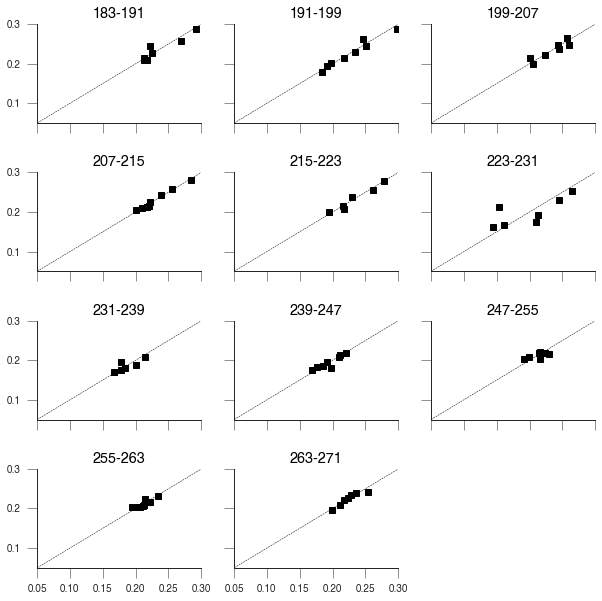

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, squeeze=True, figsize=(10,10))
axs = axs.flatten()
doy_start = 183
doy_end = doy_start + 8
fwd_arr = []
doys_arr = []
f_arr = []
t_axs = []
rmses = []
i = 0
while doy_end <= 273:
    plt.sca(axs[i])
    print(f"{doy_start:d}-{doy_end:d}")
    obs, fwd, passer, f, rmse = invert_composite ( qa, doys, rho, kern, doy_start, doy_end )
    plt.title(f"{doy_start:d}-{doy_end:d}")
    sel_doys = np.logical_and(qa == 1, np.logical_and(
                              doys > doy_start, doys <= doy_end))
    doys_arr.append(sel_doys)
    doy_end = doy_end + 8
    doy_start = doy_start + 8
    i += 1
    t_axs.append((doy_start + doy_end)/2)
    f_arr.append(f)
    fwd_arr.append(fwd)
    rmses.append(rmse)
axs[-1].set_visible(False)


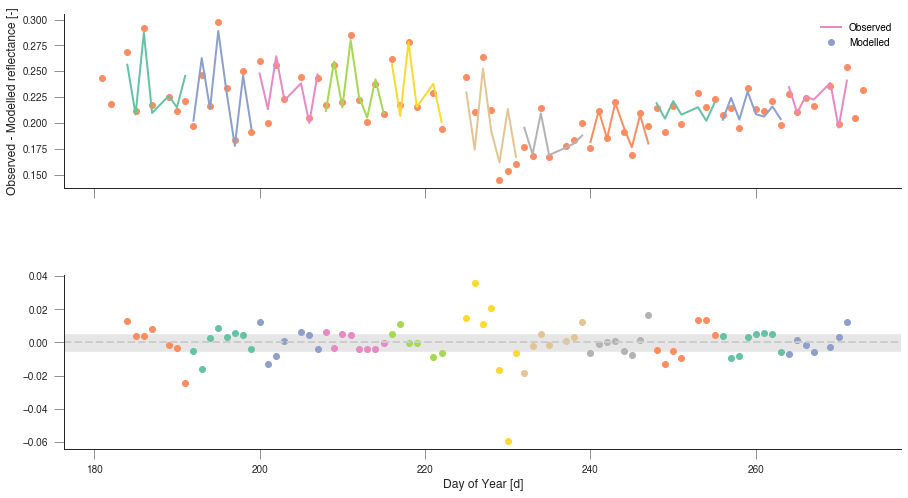

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,8))
axs[0].plot(doys[qa==1], rho[qa==1], 'o')
for i, sel_doy in enumerate(doys_arr):
    l1 = axs[0].plot(doys[sel_doy], fwd_arr[i], '-', label="Observed")
    l2 = axs[1].plot(doys[sel_doy], rho[sel_doy] - fwd_arr[i], 'o', label="Modelled")
lines = l1 + l2
labels = [l.get_label() for l in lines]
axs[0].legend(lines, labels, loc="best", frameon=False)
axs[0].set_ylabel("Surface reflectance [-]")
axs[0].set_ylabel("Observed - Modelled reflectance [-]")
axs[1].set_xlabel("Day of Year [d]")
axs[1].axhspan(-0.005, 0.005, color="0.9")
axs[1].axhline(0, color="0.8", ls="--")



So, it would appear that things work reasonably well... For most of the time, the residuals of the inversion are within 0.01 units of reflectance from the observations, except around the time of the fire, where the rapid change clearly breaks the smoothness assumption. After the fire, we also see some outliers, possibly due to the fast post-fire reflectance recovery signal. Let's look at how the parameter vary:

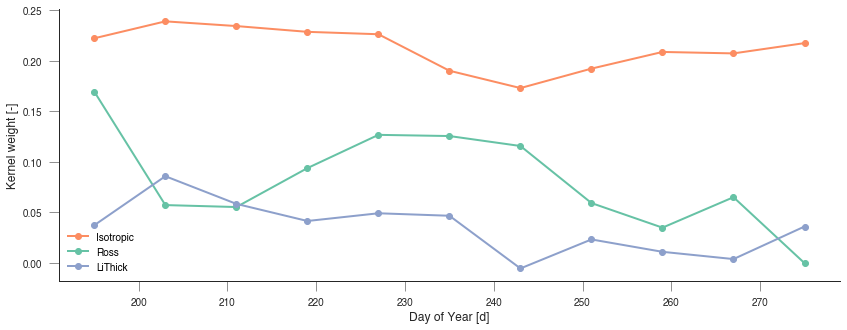

In [13]:
plt.figure(figsize=(14,5))
f = np.array(f_arr)
rmses = np.array(rmses)
for i, k in enumerate(["Isotropic", "Ross", "LiThick"]):
    plt.plot(t_axs, f[:, i], 'o-', label=k)
_ = plt.legend(loc="best", frameon=False)
_ = plt.xlabel("Day of Year [d]")
_ = plt.ylabel("Kernel weight [-]")

So it is clear that the fire dip is visible in the isotropic kernel weight. We see that the two other weights are apparently quite noisy. But we haven't put any error bars in the estimates: it may be that they are indeed all over the place, but the uncertainty might be large (in which case, we do not have enough evidence to zoom in in one value), or if the uncertainty is very low, it may mean that things are changing vastly.

So we need to look at uncertainty, which we'll do in another notebook!